# PicTex Text Detection Model

Len Huang. Given a square image of handwritten text, return its class.

### Step 1: Import Dataset

Taken from TowardsDataScience.
https://discuss.pytorch.org/t/transforming-3-channel-image-to-greyscale-1-channel/48463/5

In [34]:
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch

data_dir = 'datasets/our_images/train'
def load_split_train_test(datadir, valid_size = .2):
    transform = transforms.Compose(
        [transforms.Resize((32, 32)), 
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    train_data = datasets.ImageFolder(datadir, transform)
    test_data = datasets.ImageFolder(datadir, transform)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)

    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)

# WE'LL NEED TO DEFINE CLASSES FOR LATER
classes = trainloader.dataset.classes
print("Classes are:")
print(trainloader.dataset.classes)
print("Train loader is:")
print(trainloader)
print("Test loader is:")
print(testloader)

Classes are:
['add', 'equal', 'minus', 'times']
Train loader is:
Test loader is:


### Step 1.5? Image Augmentation

In [35]:
# TODO: Image augmentation

### Step 2: Create CNN

https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

In [36]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2) # idk what this does
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Transitioning from Conv ===> Linear
        # 16 is the number of output channels in the previous conv layer.
        # not sure what 5 is...
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# init the class 
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Step 3: Loss Function and Optimizer

Adam/SGD and Cross Entrop Loss

In [37]:
import torch.optim as optim

def loss_optim():
    criterion = nn.CrossEntropyLoss()
    # Adam
    # optimizer = optim.Adam(net.parameters(), lr=0.001)
    # SGD. Momentum = remembering previous estimation change for a param (delta W)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    return criterion, optimizer

criterion, optimizer = loss_optim()
print(criterion)
print(optimizer)

CrossEntropyLoss()
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


### Step 4: Train Model

In [38]:
def train_network():
    for epoch in range(10):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            # test_loss += loss.item()
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    PATH = './models/pictex_text_detect.pth'
    torch.save(net.state_dict(), PATH)
    print('Finished Training')

def visualize_train(train_losses, test_losses):
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()
    
train_network()

Finished Training


### Step 5: Test the Network

https://stackoverflow.com/questions/13214809/pretty-print-2d-python-list

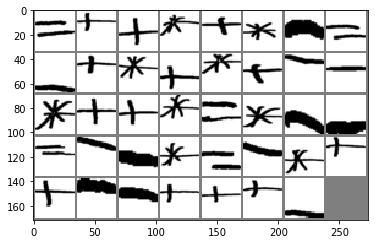

equal	add  	add  	times	add  	times	minus	equal
add  	add  	times	add  	times	minus	equal	minus
add  	times	add  	times	minus	equal	minus	add  
times	add  	times	minus	equal	minus	add  	times
add  	times	minus	equal	minus	add  	times	add  


In [64]:
import matplotlib.pyplot as plt
import torchvision.utils as tvu


# Function to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy() # numpy-ify image
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display Content in 5 rows 8 cols matrix
def display_class(labels):
    results = []
    for i in range(5):
        row = []
        for j in range(8):
            index = i + 1 * j
            prediction = classes[labels[index]]
            row.append(prediction)
        results.append(row)
    # Fancy code I found on StackOverflow
    s = [[str(e) for e in row] for row in results]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    print('\n'.join(table))
    
        

def test_data():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(tvu.make_grid(images))
    display_class(labels)

imshow = show_image()
test_data()